In [1]:
import numpy as np
import cv2
import pandas as pd
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.ensemble import RandomForestClassifier
import rasterio as rio
from sklearn.model_selection import train_test_split
import pickle

In [4]:
img = cv2.imread('../../data/data/ortho_train.tif')

In [69]:
img.shape

(7068, 5160, 3)

In [5]:
imgB = img[:, :, 0]
imgG = img[:, :, 1]
imgR = img[:, :, 2]

In [6]:
imgB1 = imgB.reshape(-1)
imgG1 = imgG.reshape(-1)
imgR1 = imgR.reshape(-1)

In [7]:
df = pd.DataFrame()

In [8]:
df['original_imgB'] = imgB1
df['original_imgG'] = imgG1
df['original_imgR'] = imgR1

In [41]:
def Gabor_features(df, img, label):
    num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []  #Create empty list to hold all kernels that we will generate in a loop
    for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with values of 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5

                    gabor_label = f'Gabor_{label}' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1  #Increment for gabor column label
    return df

In [10]:
for ind, val in enumerate([imgB1, imgG1, imgR1]):
    labels = ['B', 'G' , 'R']
    df = Gabor_features(df, val, labels[ind])

Gabor_B1
Gabor_B1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor_B2
Gabor_B2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor_B3
Gabor_B3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor_B4
Gabor_B4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor_B5
Gabor_B5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor_B6
Gabor_B6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor_B7
Gabor_B7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor_B8
Gabor_B8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor_B9
Gabor_B9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor_B10
Gabor_B10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor_B11
Gabor_B11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor_B12
Gabor_B12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor_B13
Gabor_B13 : theta= 0.0 : sigma= 3 : lamda= 1

Gabor_R30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor_R31
Gabor_R31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
Gabor_R32
Gabor_R32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5


In [43]:
def extract_features(df, img, label):
    
    #Canny Edge
    print(f"Calculating Canny Edge for {label}")
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    edges1 = edges.reshape(-1)
    df[f'Canny Edge_{label}'] = edges1 #Add column to original dataframe
    
    #ROBERTS EDGE
    print(f"Calculating Robert's Edge for {label}")
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df[f'Roberts_{label}'] = edge_roberts1

    #SOBEL
    print(f"Calculating Sobel Edge for {label}")
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df[f'Sobel_{label}'] = edge_sobel1

    #SCHARR
    print(f"Calculating Scharr Edge for {label}")
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df[f'Scharr_{label}'] = edge_scharr1

    #PREWITT
    print(f"Calculating Prewitt Edge for {label}")
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df[f'Prewitt_{label}'] = edge_prewitt1

    #GAUSSIAN with sigma=3
    print(f"Calculating Gaussian Filter (sigma 3) for {label}")
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df[f'Gaussian_s3_{label}'] = gaussian_img1

    #GAUSSIAN with sigma=7
    print(f"Calculating Gaussian Filter (sigma 7) for {label}")
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df[f'Gaussian_s7_{label}'] = gaussian_img3

    #MEDIAN with sigma=3
    print(f"Calculating Median Filter (sigma 3) for {label}")
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df[f'Median_s3_{label}'] = median_img1

    #VARIANCE with size=3
    print(f"Calculating Variance Filter (sigma 3) for {label}")
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df[f'Variance_s3_{label}'] = variance_img1  #Add column to original dataframe
    
    return df

In [12]:
for ind, val in enumerate([imgB, imgG, imgR]):
    labels = ['B', 'G' , 'R']
    df = extract_features(df, val, labels[ind])

Calculating Canny Edge for B
Calculating Robert's Edge for B
Calculating Sobel Edge for B
Calculating Scharr Edge for B
Calculating Prewitt Edge for B
Calculating Gaussian Filter (sigma 3) for B
Calculating Gaussian Filter (sigma 7) for B
Calculating Median Filter (sigma 3) for B
Calculating Variance Filter (sigma 3) for B
Calculating Canny Edge for G
Calculating Robert's Edge for G
Calculating Sobel Edge for G
Calculating Scharr Edge for G
Calculating Prewitt Edge for G
Calculating Gaussian Filter (sigma 3) for G
Calculating Gaussian Filter (sigma 7) for G
Calculating Median Filter (sigma 3) for G
Calculating Variance Filter (sigma 3) for G
Calculating Canny Edge for R
Calculating Robert's Edge for R
Calculating Sobel Edge for R
Calculating Scharr Edge for R
Calculating Prewitt Edge for R
Calculating Gaussian Filter (sigma 3) for R
Calculating Gaussian Filter (sigma 7) for R
Calculating Median Filter (sigma 3) for R
Calculating Variance Filter (sigma 3) for R


In [13]:
df.shape

(36470880, 126)

In [15]:
with rio.open("../../data/data/tree_mask_train.tif") as tm:
    labeled_img = tm.read(1)

In [16]:
mask_shape = labeled_img.shape

In [15]:
labeled_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

In [20]:
with open("../../data/dataframe.pkl", 'wb') as out:
    pickle.dump(df, out)

In [2]:
with open("../../data/dataframe.pkl", 'rb') as inbound:
    df = pickle.load(inbound)

In [10]:
np.random.seed(7)

remove_n = round(df.shape[0]*0.9)
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [13]:
del df

In [11]:
df_subset.shape

(3647088, 127)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_subset.drop(labels = ['Labels'], axis=1), df_subset[['Labels']], random_state = 7)



In [14]:
RFM = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 7)

In [15]:
RFM.fit(X_train, y_train)

<ipython-input-15-37c1713c4963>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFM.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [16]:
test_preds = RFM.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

In [18]:
accuracy_score(y_test, test_preds)

0.9548867480027902

In [24]:
df_subset[df_subset['Labels'] == 0].shape[0]/df_subset.shape[0] * 100

94.89540696577653

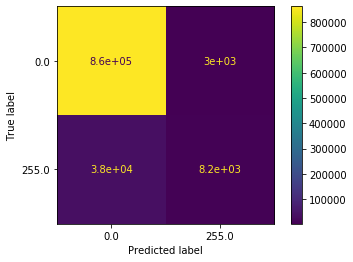

In [32]:
plot_confusion_matrix(RFM, X_test, y_test)

In [27]:
RFM.feature_importances_

array([1.32559751e-02, 1.32631385e-02, 1.38495854e-02, 0.00000000e+00,
       0.00000000e+00, 1.83940081e-03, 1.24343808e-02, 1.67945409e-02,
       1.44826220e-02, 1.54014890e-02, 1.28487977e-02, 0.00000000e+00,
       0.00000000e+00, 6.14785247e-03, 7.65559537e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.29526853e-03, 7.02317078e-04, 1.53724137e-02,
       2.24571584e-03, 1.71552844e-02, 1.11714190e-02, 0.00000000e+00,
       0.00000000e+00, 2.06613885e-03, 8.96055758e-05, 1.62587776e-02,
       1.36820281e-02, 1.56156670e-02, 1.52715121e-02, 0.00000000e+00,
       0.00000000e+00, 1.28900987e-03, 6.00105709e-03, 1.29599883e-02,
       1.32671612e-02, 1.24038605e-02, 9.56912059e-03, 0.00000000e+00,
       0.00000000e+00, 3.69439937e-03, 4.65664221e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.45777328e-04, 2.62884426e-04, 1.26411483e-02,
      

In [33]:
with open("RFM.pkl", 'wb') as out:
    pickle.dump(RFM, out)

## Predict with Eval Data

In [7]:
eval_data = cv2.imread("../../data/eval_data/ortho_eval.tif")

In [35]:
evalB = eval_data[:, :, 0]
evalG = eval_data[:, :, 1]
evalR = eval_data[:, :, 2]

In [36]:
evalB1 = evalB.reshape(-1)
evalG1 = evalG.reshape(-1)
evalR1 = evalR.reshape(-1)

In [37]:
df_eval = pd.DataFrame()

In [39]:
df_eval['original_B'] = evalB1
df_eval['original_G'] = evalG1
df_eval['original_R'] = evalR1

In [42]:
for ind, val in enumerate([evalB1, evalG1, evalR1]):
    labels = ['B', 'G' , 'R']
    df_eval = Gabor_features(df_eval, val, labels[ind])

Gabor_B1
Gabor_B1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor_B2
Gabor_B2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor_B3
Gabor_B3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor_B4
Gabor_B4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor_B5
Gabor_B5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor_B6
Gabor_B6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor_B7
Gabor_B7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor_B8
Gabor_B8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor_B9
Gabor_B9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor_B10
Gabor_B10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor_B11
Gabor_B11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor_B12
Gabor_B12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor_B13
Gabor_B13 : theta= 0.0 : sigma= 3 : lamda= 1

Gabor_R30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor_R31
Gabor_R31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
Gabor_R32
Gabor_R32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5


In [44]:
for ind, val in enumerate([evalB, evalG, evalR]):
    labels = ['B', 'G' , 'R']
    df_eval = extract_features(df_eval, val, labels[ind])

Calculating Canny Edge for B
Calculating Robert's Edge for B
Calculating Sobel Edge for B
Calculating Scharr Edge for B
Calculating Prewitt Edge for B
Calculating Gaussian Filter (sigma 3) for B
Calculating Gaussian Filter (sigma 7) for B
Calculating Median Filter (sigma 3) for B
Calculating Variance Filter (sigma 3) for B
Calculating Canny Edge for G
Calculating Robert's Edge for G
Calculating Sobel Edge for G
Calculating Scharr Edge for G
Calculating Prewitt Edge for G
Calculating Gaussian Filter (sigma 3) for G
Calculating Gaussian Filter (sigma 7) for G
Calculating Median Filter (sigma 3) for G
Calculating Variance Filter (sigma 3) for G
Calculating Canny Edge for R
Calculating Robert's Edge for R
Calculating Sobel Edge for R
Calculating Scharr Edge for R
Calculating Prewitt Edge for R
Calculating Gaussian Filter (sigma 3) for R
Calculating Gaussian Filter (sigma 7) for R
Calculating Median Filter (sigma 3) for R
Calculating Variance Filter (sigma 3) for R


In [45]:
with open("../../data/eval_dataframe.pkl", 'wb') as out:
    pickle.dump(df_eval, out)

In [ ]:
#eval_preds = RFM.predict(df_eval)

In [3]:
with open("RFM.pkl", 'rb') as model:
    RFM = pickle.load(model)

In [2]:
with open("../../data/eval_dataframe.pkl", 'rb') as inbound:
    df_eval = pickle.load(inbound)

In [5]:
eval_preds = np.array([])
for i in list(range(0, 1000)):
    df = df_eval.iloc[i*int(len(df_eval)/1000):(i+1)*int(len(df_eval)/1000), :]
    preds = RFM.predict(df)
    eval_preds = np.concatenate((eval_preds, preds), axis = 0)
    

In [13]:
first_row = 0
last_row = int(first_row + len(df_eval)/1000)
eval_preds = np.array([])
while (last_row <= len(df_eval)) and (first_row != last_row):
    print(f"First Row: {first_row}, Last Row: {last_row}")
    df_chunk = df_eval.iloc[first_row:last_row, :]
    preds_chunk = RFM.predict(df_chunk)
    eval_preds = np.concatenate((eval_preds, preds_chunk), axis = 0)
    first_row = last_row
    if len(df_eval) - last_row < len(df_eval)/1000:
        df_chunk = df_eval.iloc[first_row:, :]
        preds_chunk = RFM.predict(df_chunk)
        eval_preds = np.concatenate((eval_preds, preds_chunk), axis = 0)
        break
    else:
        last_row = int(first_row + len(df_eval)/1000)

First Row: 0, Last Row: 36470
First Row: 36470, Last Row: 72940
First Row: 72940, Last Row: 109410
First Row: 109410, Last Row: 145880
First Row: 145880, Last Row: 182350
First Row: 182350, Last Row: 218820
First Row: 218820, Last Row: 255290
First Row: 255290, Last Row: 291760
First Row: 291760, Last Row: 328230
First Row: 328230, Last Row: 364700
First Row: 364700, Last Row: 401170
First Row: 401170, Last Row: 437640
First Row: 437640, Last Row: 474110
First Row: 474110, Last Row: 510580
First Row: 510580, Last Row: 547050
First Row: 547050, Last Row: 583520
First Row: 583520, Last Row: 619990
First Row: 619990, Last Row: 656460
First Row: 656460, Last Row: 692930
First Row: 692930, Last Row: 729400
First Row: 729400, Last Row: 765870
First Row: 765870, Last Row: 802340
First Row: 802340, Last Row: 838810
First Row: 838810, Last Row: 875280
First Row: 875280, Last Row: 911750
First Row: 911750, Last Row: 948220
First Row: 948220, Last Row: 984690
First Row: 984690, Last Row: 1021160


First Row: 7986930, Last Row: 8023400
First Row: 8023400, Last Row: 8059870
First Row: 8059870, Last Row: 8096340
First Row: 8096340, Last Row: 8132810
First Row: 8132810, Last Row: 8169280
First Row: 8169280, Last Row: 8205750
First Row: 8205750, Last Row: 8242220
First Row: 8242220, Last Row: 8278690
First Row: 8278690, Last Row: 8315160
First Row: 8315160, Last Row: 8351630
First Row: 8351630, Last Row: 8388100
First Row: 8388100, Last Row: 8424570
First Row: 8424570, Last Row: 8461040
First Row: 8461040, Last Row: 8497510
First Row: 8497510, Last Row: 8533980
First Row: 8533980, Last Row: 8570450
First Row: 8570450, Last Row: 8606920
First Row: 8606920, Last Row: 8643390
First Row: 8643390, Last Row: 8679860
First Row: 8679860, Last Row: 8716330
First Row: 8716330, Last Row: 8752800
First Row: 8752800, Last Row: 8789270
First Row: 8789270, Last Row: 8825740
First Row: 8825740, Last Row: 8862210
First Row: 8862210, Last Row: 8898680
First Row: 8898680, Last Row: 8935150
First Row: 8

First Row: 15572690, Last Row: 15609160
First Row: 15609160, Last Row: 15645630
First Row: 15645630, Last Row: 15682100
First Row: 15682100, Last Row: 15718570
First Row: 15718570, Last Row: 15755040
First Row: 15755040, Last Row: 15791510
First Row: 15791510, Last Row: 15827980
First Row: 15827980, Last Row: 15864450
First Row: 15864450, Last Row: 15900920
First Row: 15900920, Last Row: 15937390
First Row: 15937390, Last Row: 15973860
First Row: 15973860, Last Row: 16010330
First Row: 16010330, Last Row: 16046800
First Row: 16046800, Last Row: 16083270
First Row: 16083270, Last Row: 16119740
First Row: 16119740, Last Row: 16156210
First Row: 16156210, Last Row: 16192680
First Row: 16192680, Last Row: 16229150
First Row: 16229150, Last Row: 16265620
First Row: 16265620, Last Row: 16302090
First Row: 16302090, Last Row: 16338560
First Row: 16338560, Last Row: 16375030
First Row: 16375030, Last Row: 16411500
First Row: 16411500, Last Row: 16447970
First Row: 16447970, Last Row: 16484440


First Row: 23049040, Last Row: 23085510
First Row: 23085510, Last Row: 23121980
First Row: 23121980, Last Row: 23158450
First Row: 23158450, Last Row: 23194920
First Row: 23194920, Last Row: 23231390
First Row: 23231390, Last Row: 23267860
First Row: 23267860, Last Row: 23304330
First Row: 23304330, Last Row: 23340800
First Row: 23340800, Last Row: 23377270
First Row: 23377270, Last Row: 23413740
First Row: 23413740, Last Row: 23450210
First Row: 23450210, Last Row: 23486680
First Row: 23486680, Last Row: 23523150
First Row: 23523150, Last Row: 23559620
First Row: 23559620, Last Row: 23596090
First Row: 23596090, Last Row: 23632560
First Row: 23632560, Last Row: 23669030
First Row: 23669030, Last Row: 23705500
First Row: 23705500, Last Row: 23741970
First Row: 23741970, Last Row: 23778440
First Row: 23778440, Last Row: 23814910
First Row: 23814910, Last Row: 23851380
First Row: 23851380, Last Row: 23887850
First Row: 23887850, Last Row: 23924320
First Row: 23924320, Last Row: 23960790


First Row: 30525390, Last Row: 30561860
First Row: 30561860, Last Row: 30598330
First Row: 30598330, Last Row: 30634800
First Row: 30634800, Last Row: 30671270
First Row: 30671270, Last Row: 30707740
First Row: 30707740, Last Row: 30744210
First Row: 30744210, Last Row: 30780680
First Row: 30780680, Last Row: 30817150
First Row: 30817150, Last Row: 30853620
First Row: 30853620, Last Row: 30890090
First Row: 30890090, Last Row: 30926560
First Row: 30926560, Last Row: 30963030
First Row: 30963030, Last Row: 30999500
First Row: 30999500, Last Row: 31035970
First Row: 31035970, Last Row: 31072440
First Row: 31072440, Last Row: 31108910
First Row: 31108910, Last Row: 31145380
First Row: 31145380, Last Row: 31181850
First Row: 31181850, Last Row: 31218320
First Row: 31218320, Last Row: 31254790
First Row: 31254790, Last Row: 31291260
First Row: 31291260, Last Row: 31327730
First Row: 31327730, Last Row: 31364200
First Row: 31364200, Last Row: 31400670
First Row: 31400670, Last Row: 31437140


In [10]:
len(df_eval)

36470880

In [14]:
eval_preds.shape

(36470880,)

In [17]:
segmented = eval_preds.reshape(mask_shape)

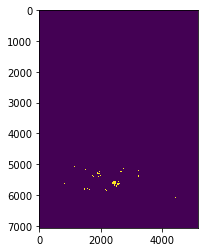

In [36]:
from matplotlib import pyplot as plt
plt.imshow(segmented, cmap ='viridis')
plt.imsave('tree_predictions.png', segmented, cmap ='viridis')

In [20]:
with rio.open("../../data/eval_data/ortho_eval.tif", 'r') as src:
    ortho_eval = src.read(masked=True)

In [25]:
with rio.open("../../data/eval_data/ortho_eval.tif", 'r') as src:
    height = src.height
    width = src.width
    crs = src.crs
    transform = src.transform

In [23]:
masked_eval = np.ma.array(segmented)

In [24]:
masked_eval.mask = ortho_eval.mask

In [26]:
masked_eval

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [29]:
output = masked_eval.astype('UInt16')

<ipython-input-29-ab671b7c987f>:1: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  output = masked_eval.astype('UInt16')


In [31]:
with rio.open("../../data/eval_data/pred_tree_mask.png", 
              'w',
              driver = "PNG",
              height = height,
              width = width,
              crs = crs,
              transform = transform,
              count = 1,
              dtype = output.dtype,
              nodata = masked_eval.fill_value) as out:
    out.write(output, 1)

In [33]:
with rio.open("../../data/eval_data/pred_tree_mask.tif", 
              'w',
              driver = "Gtiff",
              height = height,
              width = width,
              crs = crs,
              transform = transform,
              count = 1,
              dtype = masked_eval.dtype,
              nodata = masked_eval.fill_value) as out:
    out.write(masked_eval, 1)